# AP Physics C Review Lab (calculations)

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from uncertainties import ufloat, correlated_values
from uncertainties import umath, unumpy as unp
from scipy import odr

In [133]:
from IPython.display import display, Markdown

def pprint(text: str) -> None:
    display(Markdown(text))

These values are constant regardless of method.

In [134]:
# Physical constants
g = ufloat(9.81, 0.01)  # m/s^2

# Measured constants
h_table_dat = ufloat(1., 0.001)  # m

Here is where the ramp height is input for the variable-height methods:

In [135]:
# Input
h_ramp_input = ufloat(0.120, 0.001)  # m

Data is loaded here.

In [136]:
with pd.ExcelFile('../data/data.xlsx') as wkbk:
    rot_inertia_df = pd.read_excel(wkbk, 'RotInertia', index_col='trial')
rot_inertia_df

,h_ramp,h_ramp_err,t_pulse,t_pulse_err
trial,,,,
1,0.1220,0.001,0.347364,0.003536
2,0.1220,0.001,0.340719,0.003536
3,0.1220,0.001,0.340584,0.003536
4,0.1220,0.001,0.340180,0.003536
5,0.1220,0.001,0.341503,0.003536
6,0.1220,0.001,0.344146,0.003536
7,0.1220,0.001,0.342533,0.003536
8,0.1220,0.001,0.342628,0.003536
9,0.1220,0.001,0.344969,0.003536


## Method 1 (Any height)

Here the ratio before the $mr^2$ part of the rotational inertia expression can be specified. It is $\frac{2}{5}$ for a uniform sphere.

In [137]:
inertia_ratio = 2 / 5
factor = 1 / (0.5 * (1 + inertia_ratio))

Now the calculations are performed:

In [138]:
v1 = v2 = umath.sqrt(factor * g * h_ramp_input)
pprint('$v_2 = {:L}$ m/s'.format(v2))

$v_2 = 1.297 \pm 0.005$ m/s

In [139]:
dt3 = umath.sqrt(2 * h_table_dat / g)
dx3 = v2 * dt3
pprint('Place the target ${:L}$ cm from the base of the table.'.format(dx3 * 100))

Place the target $58.55 \pm 0.25$ cm from the base of the table.

## Method 2 (Any height)

This is the photogate distance used during data collection.

In [140]:
# Photogate distance
photo_dist = ufloat(0.400, 0.001 / 2.5)

Here the regression is performed:

In [141]:
# Get data
h_ramp_dat = unp.uarray(rot_inertia_df.h_ramp, rot_inertia_df.h_ramp_err)
t_pulse_dat = unp.uarray(rot_inertia_df.t_pulse, rot_inertia_df.t_pulse_err)

In [142]:
# Actually perform the regression
x = h_ramp_dat
y = 1 / (t_pulse_dat ** 2)
data = odr.RealData(unp.nominal_values(x), unp.nominal_values(y), sx=unp.std_devs(x), sy=unp.std_devs(y))
regressor = odr.ODR(data=data, model=odr.unilinear)
odr_result = regressor.run()
odr_result.pprint()

Beta: [76.59768728 -0.83455529]
Beta Std Error: [1.56658777 0.17812955]
Beta Covariance: [[ 4.39600537 -0.49380653]
 [-0.49380653  0.05683563]]
Residual Variance: 0.5582789450383805
Inverse Condition #: 0.01609453503410503
Reason(s) for Halting:
  Sum of squares convergence


In [143]:
# Learned values from the regression
slope, intercept = correlated_values(odr_result.beta, covariance_mat=odr_result.cov_beta * odr_result.res_var)
pprint(r'intercept $= {:L}$ 1/(m s^2)'.format(intercept))
pprint(r'slope $= {:L}$ m/s^2'.format(slope))

intercept $= -0.83 \pm 0.18$ 1/(m s^2)

slope $= 76.6 \pm 1.6$ m/s^2

Here a plot is created to demonstrate the model generated from data and compare to the uniform sphere prediction model.

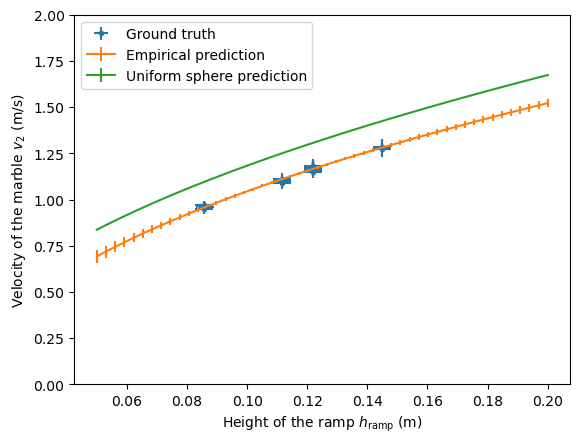

In [144]:
# Create a plot
x_test = np.linspace(0.05, 0.2)
plt.errorbar(unp.nominal_values(h_ramp_dat), unp.nominal_values(photo_dist / t_pulse_dat), 
             yerr=3 * unp.std_devs(photo_dist / t_pulse_dat), xerr=3 * unp.std_devs(h_ramp_dat),
             fmt='.', label='Ground truth')
y_pred_emp = slope * x_test + intercept
v_pred_emp = unp.sqrt(y_pred_emp) * photo_dist
plt.errorbar(x_test, unp.nominal_values(v_pred_emp), yerr=3 * unp.std_devs(v_pred_emp), label='Empirical prediction')
v_pred_mod = unp.sqrt(factor * g * x_test)
plt.errorbar(x_test, unp.nominal_values(v_pred_mod), yerr=3 * unp.std_devs(v_pred_mod), label='Uniform sphere prediction')
plt.ylim(0, 2)
plt.legend()
plt.xlabel(r'Height of the ramp $h_{\text{ramp}}$ (m)')
plt.ylabel(r'Velocity of the marble $v_2$ (m/s)')
plt.show()

Here the results for the specific ramp height are calculated:

In [150]:
v1 = v2 = umath.sqrt(slope * h_ramp_input + intercept) * photo_dist
pprint('$v_2 = {:L}$ m/s'.format(v2))

$v_2 = 1.1669 \pm 0.0030$ m/s

In [151]:
dt3 = umath.sqrt(2 * h_table_dat / g)
dx3 = v2 * dt3
pprint('Place the target ${:L}$ cm from the base of the table.'.format(dx3 * 100))

Place the target $52.69 \pm 0.14$ cm from the base of the table.

## Method 2 (Single height)

For this method, a single height is used for the calculations.

In [147]:
h_ramp_input = ufloat(rot_inertia_df.loc[1, 'h_ramp'], rot_inertia_df.loc[1, 'h_ramp_err'] / 3)
t_pulse_dat = unp.uarray(rot_inertia_df.loc[1:14, 't_pulse'], rot_inertia_df.loc[1:14, 't_pulse_err'] / 3)
t_pulse_dat

array([0.347364+/-0.0011785113019775794,
       0.340718999999999+/-0.0011785113019775794,
       0.340584+/-0.0011785113019775794,
       0.340179999999999+/-0.0011785113019775794,
       0.341502999999999+/-0.0011785113019775794,
       0.344146+/-0.0011785113019775794, 0.342533+/-0.0011785113019775794,
       0.342628+/-0.0011785113019775794,
       0.344968999999999+/-0.0011785113019775794,
       0.339916+/-0.0011785113019775794, 0.344405+/-0.0011785113019775794,
       0.337667999999999+/-0.0011785113019775794,
       0.340156999999999+/-0.0011785113019775794,
       0.34265+/-0.0011785113019775794], dtype=object)

Here the results are calculated.

In [148]:
v1 = v2 = sum(photo_dist / t_pulse_dat) / len(t_pulse_dat)
pprint('$v_2 = {:L}$ m/s'.format(v2))

$v_2 = 1.1693 \pm 0.0016$ m/s

In [149]:
dt3 = umath.sqrt(2 * h_table_dat / g)
dx3 = v2 * dt3
pprint('Place the target ${:L}$ cm from the base of the table and the ramp ${:L}$ cm off the surface of the table.'.format(dx3 * 100, h_ramp_input * 100))

Place the target $52.80 \pm 0.08$ cm from the base of the table and the ramp $12.200 \pm 0.033$ cm off the surface of the table.